# Project 2: Ames Housing Saleprice Prediction
---
Project notebook organisation:<br>
**1 - EDA and Data Cleaning** (current notebook)<br>
[2 - Preprocessing and Feature Engineering](./2_preprocessing_and_feature_engineering.ipynb)<br>
[3 - Model Tuning and Insights](./3_model_tuning_and_insights.ipynb)<br>
[3.1 - Model Performance with Automated Feature Selection](3_(appendix)_automated_feature_selection)<br>
<br>
<br>

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

sns.set_style('ticks')

pd.set_option('display.max_columns', None)

%matplotlib inline

## Introduction & problem statement
   ---

This project examines a comprehensive housing dataset from the city of Ames in Iowa, USA ([source](https://www.kaggle.com/c/dsi-us-6-project-2-regression-challenge/overview)). Homeowners looking to increase the value of their homes often spend too much remodelling and don't get the return on investment when selling the house. On the other hand, people looking to buy houses want to get the best house possible given a budget. The goal of this project is to address some of these concerns, specifically:
- what features add the most value to a home, and which hurt home values the most?
- given a set of features, what is the expected sale price of a house? 
- given a budget, what kind of house would one be able to afford?

To answer these questions, I fitted different linear regression models to the housing data in order to determine the features that are most influential on house price, and those that have the least effect. The performance of the models will be evaluated using the R<sup>2</sup> metric, which is a measure of how much the model is able to explain the variance in the dataset.

Due to the scale of this project, it is split into fourJupyter notebooks: EDA and data cleaning, preprocessing and feature engineering, and model tuning and insights (along with an appendix showing some additional model results where I attempted automated feature selection with the [`featuretools` library](https://github.com/Featuretools/featuretools)). This is the EDA and data cleaning notebook.

### Contents

1. [First impressions](#First-impressions)
2. [Null values](#Null-values)
3. [Feature distributions](#Feature-distributions)
4. [Closer examination of features](#Closer-examinations)
5. [Correlations and collinear features](#Collinear-features)
6. [Possible explanatory variables](#Possible-explanatory-variables)
7. [Conclusion](#Conclusion)

## Executive summary
---

An elastic net regression model had the best predictive performance on housing sale price in Ames USA, and outperformed the other linear models tested. The model revealed that square feet area, condition, age, and the location of the house are the most important determinant factors of how much a house sells for.

For house buyers with specific budgets, this model would allow one to figure out what features they would be able to afford given an amount of money. For those looking to invest, houses in the Northridge Heights, Stone Brook, and Northridge neighbourhoods all had higher prices compared to other neighbourhoods. Conversely, people looking to sell their house would be able to use the model to get an estimate of how much they would be able to sell their house for. If one is looking to sell, they should do it sooner rather than later, as the age of the house is the biggest contributing factor to the decrease in value. Having a garage in bad condition also negatively affect value, as does having a second floor to the house. And unsurprisingly, if the house is severely damaged, its value drops. As such, those looking to increase the value of their home could consider increasing the square footage of their house, renovating the kitchen and garage, and adding a fireplace.

The model may however have limited applicabilities, as it was developed using data on houses sold between 2006 - 2010 in Ames, USA. This dataset is limited in scope both in terms of the time frame captured, as well as location. The small time frame of four years is not enough to capture any annual changes in sale price that could arise as a result of external factors, such as the current economy. Housing prices at present (in 2019) may also have changed as a result of inflation. The model is also specific to houses in Ames and may not be as accurate when applied to data from another city or country, where house prices may be affected by different things than for example, garage quality.

In reality, house price may be difficult to predict as it is also affected by buyers' psychology, the economic climate, and other factors not included in the present dataset. There will never be a perfect model; the aim of this model is therefore not to give a perfect prediction, but act as a guideline to inform decisions.

## First impressions
---

The Ames housing data set contains 2051 entries with 81 features, representing characteristics of houses sold between 2006 - 2010. The characteristics/features can be roughly divided into 4 categories:
- House features (e.g. foundation, masonry type, utilities)
- Size (e.g. total basement square feet, number of bedrooms, pool area)
- Location (e.g. mszoning, neighbourhood)
- Environment (e.g. alley, landslope)
- Date-related (e.g. year built, garage year built, year sold)

The features can also be classified into the following types:
- Numerical (e.g. general living area)
- Categorical (ordinal) (e.g. fireplace quality)
- Categorical (e.g. street type)

One can see from the column summaries below that some categorical columns are extremely skewed towards one value (e.g. street and utilities), or are mostly zeros (e.g. poolqc).

In [2]:
# import train
train = pd.read_csv ("../data/train.csv")

# make columns lowercase and remove spaces
train.columns = train.columns.str.lower()
train.columns = train.columns.str.replace(' ', '')

print(train.columns)
print(train.info())
train.head(5)

Index(['id', 'pid', 'mssubclass', 'mszoning', 'lotfrontage', 'lotarea',
       'street', 'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig',
       'landslope', 'neighborhood', 'condition1', 'condition2', 'bldgtype',
       'housestyle', 'overallqual', 'overallcond', 'yearbuilt',
       'yearremod/add', 'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd',
       'masvnrtype', 'masvnrarea', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1',
       'bsmtfintype2', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating',
       'heatingqc', 'centralair', 'electrical', '1stflrsf', '2ndflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'kitchenqual',
       'totrmsabvgrd', 'functional', 'fireplaces', 'fireplacequ', 'garagetype',
       'garageyrblt', 'garagefinish', 'garagecars', 'garagearea', 'garagequal',
       'garagecond', 'pa

,id,pid,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremod/add,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,saleprice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NaN,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,GasA,TA,Y,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,TA,6,Typ,0,NaN,Detchd,1957.0,Unf,2.0,484.0,TA,TA,N,0,59,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [3]:
# for str columns, print count of unique values
# for numerical columns, print % of zeros.

def data_summaries (df):
    for col in df.columns:
        print ("------ %s ------" % col)
        if df[col].dtype == np.object:
            print (df[col].value_counts())
        elif len(df[df[col] == 0]) >= 1026:
            print (col, '\n', '% zeros (HIGH!): ', round((len(df[df[col] == 0])/2051)*100),\
                   '\n', 'no. zeros: ',len(df[df[col]==0]))
        else:
            print (col, '\n', '% zeros: ', round((len(df[df[col] == 0])/2051)*100))
        print ('\n')
    
data_summaries(train)

------ id ------
id 
 % zeros:  0


------ pid ------
pid 
 % zeros:  0


------ mssubclass ------
mssubclass 
 % zeros:  0


------ mszoning ------
RL         1598
RM          316
FV          101
C (all)      19
RH           14
A (agr)       2
I (all)       1
Name: mszoning, dtype: int64


------ lotfrontage ------
lotfrontage 
 % zeros:  0


------ lotarea ------
lotarea 
 % zeros:  0


------ street ------
Pave    2044
Grvl       7
Name: street, dtype: int64


------ alley ------
Grvl    85
Pave    55
Name: alley, dtype: int64


------ lotshape ------
Reg    1295
IR1     692
IR2      55
IR3       9
Name: lotshape, dtype: int64


------ landcontour ------
Lvl    1843
HLS      85
Bnk      80
Low      43
Name: landcontour, dtype: int64


------ utilities ------
AllPub    2049
NoSeWa       1
NoSewr       1
Name: utilities, dtype: int64


------ lotconfig ------
Inside     1503
Corner      348
CulDSac     131
FR2          60
FR3           9
Name: lotconfig, dtype: int64


------ landslop

### Summary statistics

The 2051 houses captured in this dataset were built from 1872 to 2010. The average living area (`grlivarea`) was 1499 square feet (sf) (SD = 500 sf), with the smallest house having 334 sf and the largest having 5642 sf.

Of the houses with basements, the mean total basement area (`totalbsmtsf`) was 1058 sf (SD = 449 sf). The smallest basement was 0 sf (representing houses with no basements), and the largest was 6110 sf.

The average garage area (`garagearea`) was 474 sf (SD = 216). The smallest garage was 0 sf (no garage), and the largest was 1418 sf (bigger than the smallest house).

The average number of rooms in a house (`totrmsabvgrd`) was 6.43. The smallest house had 2 rooms, while the largest had 15. 

The average price (`saleprice`) for the houses was \\$181470 (presumably in USD) (SD = $7926). The cheapest house sold in this period cost \\$12789, while the most expensive cost \\$611657. 

In [4]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,2051.0,1.474034e+03,8.439808e+02,1.0,753.5,1486.0,2.198000e+03,2930.0
pid,2051.0,7.135900e+08,1.886918e+08,526301100.0,528458140.0,535453200.0,9.071801e+08,924152030.0
mssubclass,2051.0,5.700878e+01,4.282422e+01,20.0,20.0,50.0,7.000000e+01,190.0
lotfrontage,1721.0,6.905520e+01,2.326065e+01,21.0,58.0,68.0,8.000000e+01,313.0
lotarea,2051.0,1.006521e+04,6.742489e+03,1300.0,7500.0,9430.0,1.151350e+04,159000.0
overallqual,2051.0,6.112140e+00,1.426271e+00,1.0,5.0,6.0,7.000000e+00,10.0
overallcond,2051.0,5.562165e+00,1.104497e+00,1.0,5.0,5.0,6.000000e+00,9.0
yearbuilt,2051.0,1.971709e+03,3.017789e+01,1872.0,1953.5,1974.0,2.001000e+03,2010.0
yearremod/add,2051.0,1.984190e+03,2.103625e+01,1950.0,1964.5,1993.0,2.004000e+03,2010.0
masvnrarea,2029.0,9.969591e+01,1.749631e+02,0.0,0.0,0.0,1.610000e+02,1600.0


## Null values
---

There are 26 columns with varying amounts of null values, ranging from 1 to 2042. 

Looking at the categorical columns and comparing their unique values with the [data dictionary](https://www.kaggle.com/c/dsi-us-6-project-2-regression-challenge/data), it is likely that the null values represent houses without those features, e.g. without a garage, pool, or fireplace. The missing values in some numerical columns correspond to those as well, e.g. houses without masonry veneer also have null values for masvnrarea. The nulls in these categorical columns will be filled with "None", and those in numerical columns will be filled with 0.

Some columns only have 1 or 2 null values, these are likely errors in recording. Those rows will be dropped.

In [5]:
# print count of nulls for columns containing nulls
nulldf = pd.DataFrame(train.isnull().sum(), columns = ['nullcount'])
nulldf = nulldf[nulldf['nullcount'] != 0]
print(nulldf.shape)
nulldf

(26, 1)


,nullcount
lotfrontage,330
alley,1911
masvnrtype,22
masvnrarea,22
bsmtqual,55
bsmtcond,55
bsmtexposure,58
bsmtfintype1,55
bsmtfinsf1,1
bsmtfintype2,56


In [6]:
train.alley.value_counts()

Grvl    85
Pave    55
Name: alley, dtype: int64

In [7]:
train.bsmtqual.value_counts() 

TA    887
Gd    864
Ex    184
Fa     60
Po      1
Name: bsmtqual, dtype: int64

In [8]:
train.fireplacequ.value_counts() 

Gd    523
TA    407
Fa     59
Po     31
Ex     31
Name: fireplacequ, dtype: int64

In [9]:
train.garagequal.value_counts() 

TA    1832
Fa      82
Gd      18
Ex       3
Po       2
Name: garagequal, dtype: int64

In [10]:
train.poolqc.value_counts()

Gd    4
Fa    2
TA    2
Ex    1
Name: poolqc, dtype: int64

In [11]:
# there are 22 rows with missing values in masvnrtype and masvnrarea
# these correspond to the 22 missing values in both columns
print(train[train[['masvnrtype','masvnrtype']].isnull().any(axis=1)][['masvnrtype','masvnrtype']].shape)
train[train[['masvnrtype','masvnrtype']].isnull().any(axis=1)][['masvnrtype','masvnrtype']]

(22, 2)


,masvnrtype,masvnrtype
22,NaN,NaN
41,NaN,NaN
86,NaN,NaN
212,NaN,NaN
276,NaN,NaN
338,NaN,NaN
431,NaN,NaN
451,NaN,NaN
591,NaN,NaN
844,NaN,NaN


In [12]:
# garagecars only has 1 null value. it doesn't seem to be a notable row to keep. 
train[train['garagecars'].isnull()]

,id,pid,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremod/add,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,saleprice
1712,2237,910201180,70,RM,50.0,9060,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,6,1923,1999,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,BrkTil,Gd,TA,No,ALQ,548.0,Unf,0.0,311.0,859.0,GasA,Ex,Y,SBrkr,942,886,0,1828,0.0,0.0,2,0,3,1,Gd,6,Typ,0,NaN,Detchd,NaN,NaN,NaN,NaN,NaN,NaN,Y,174,0,212,0,0,0,NaN,MnPrv,NaN,0,3,2007,WD,150909


In [13]:
# bsmtfullbath has 2 null values, which also represent the 2 null values in bsmthalfbath, and the 1 null
# in bsmtfinsf2 and bsmtfinsf1
# they also don't appear to be notable rows
train[train['bsmtfullbath'].isnull()]

,id,pid,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremod/add,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,saleprice
616,1498,908154080,20,RL,123.0,47007,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,7,1959,1996,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,Slab,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,TA,Y,SBrkr,3820,0,0,3820,NaN,NaN,3,1,5,1,Ex,11,Typ,2,Gd,Attchd,1959.0,Unf,2.0,624.0,TA,TA,Y,0,372,0,0,0,0,NaN,NaN,NaN,0,7,2008,WD,284700
1327,1342,903230120,20,RM,99.0,5940,Pave,NaN,IR1,Lvl,AllPub,FR3,Gtl,BrkSide,Feedr,Norm,1Fam,1Story,4,7,1946,1950,Gable,CompShg,MetalSd,CBlock,None,0.0,TA,TA,PConc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GasA,TA,Y,FuseA,896,0,0,896,NaN,NaN,1,0,2,1,TA,4,Typ,0,NaN,Detchd,1946.0,Unf,1.0,280.0,TA,TA,Y,0,0,0,0,0,0,NaN,MnPrv,NaN,0,4,2008,ConLD,79000


## Feature distributions
---

This section examines the distribution of each of the features in the dataset, using distribution plots (including histograms) and probability plots.

### Custom graph functions

In [14]:
# histogram subplots
def subplot_histograms(dataframe, list_of_columns):
    nrows = int(np.ceil(len(list_of_columns)/4)) 
    fig, ax = plt.subplots(nrows=nrows, ncols=4,figsize=(15, nrows*3.5)) 
    ax = ax.ravel() 
    for i, column in enumerate(list_of_columns): 
        ax[i].hist(dataframe[column],bins=15)
        ax[i].set_title(f'{column} distribution',fontsize=14)
        ax[i].tick_params(labelsize=12)
        ax[i].set_xlabel(column, fontsize=14)
    plt.tight_layout()
    
# scatterplot subplots
def subplot_scatter(dataframe, list_of_columns):
    nrows = int(np.ceil(len(list_of_columns)/4)) 
    fig, ax = plt.subplots(nrows=nrows, ncols=4,figsize=(15, nrows*3.5)) 
    ax = ax.ravel() 
    for i, column in enumerate(list_of_columns): 
        sns.regplot(y=dataframe.saleprice, x=dataframe[column],ax=ax[i], \
                    scatter_kws={'facecolors':'skyblue','edgecolor':'skyblue'},
                    line_kws = {'color':'grey'})
        ax[i].set_title(f'{column} vs saleprice',fontsize=14)  
        ax[i].tick_params(labelsize=12)
        ax[i].set_xlabel(column, fontsize=14)
        ax[i].set_ylabel('saleprice', fontsize=14)
    plt.tight_layout()
    
# boxplot subplots
def subplot_box(dataframe, list_of_columns):
    nrows = int(np.ceil(len(list_of_columns)/4)) 
    fig, ax = plt.subplots(nrows=nrows, ncols=4,figsize=(15, nrows*3.5)) 
    ax = ax.ravel() 
    for i, column in enumerate(list_of_columns): 
        sns.boxplot(x = dataframe[column], y = dataframe.saleprice, width = 0.3, ax = ax[i], color='skyblue')
        ax[i].set_title(column,fontsize=14)  
        ax[i].tick_params(labelsize=12)
        ax[i].set_xlabel(column, fontsize=14)
#         ax[i].set_ylabel('saleprice', fontsize=14)
    plt.tight_layout()
    
# distribution plots (histogram, boxplot, probplot)
def dist_plots(df, list_of_columns):
    nrows = len(list_of_columns)
    fig, ax = plt.subplots(nrows = nrows, ncols = 3, figsize=(15, nrows*3.5))
    ax = ax.ravel()
    for i, col in enumerate(list_of_columns):
        sns.distplot(df[col], ax = ax[i*3-3], fit = stats.norm)
        ax[i*3-3].set_title(f'{col} distribution plot',fontsize=14)
        ax[i*3-3].tick_params(labelsize=12)
        ax[i*3-3].set_xlabel(col, fontsize=14)
        
        sns.boxplot(df[col], width = 0.2, ax = ax[i*3-2])
        ax[i*3-2].set_title(f'{col} box plot',fontsize=14)
        ax[i*3-2].tick_params(labelsize=12)
        ax[i*3-2].set_xlabel(col, fontsize=14)
        
        stats.probplot(df[col], plot = ax[i*3-1])
        ax[i*3-1].set_title(f'{col} probability plot', fontsize=14)
        ax[i*3-1].tick_params(labelsize=12)
        ax[i*3-1].set_xlabel(col, fontsize=14)
    plt.tight_layout()

### Distributions

As shown in the summary above as well as the graphs below in this section, numerous columns have large amounts of 0s or are dominated by a single value (>80% in both cases), and are extremely left- or right-skewed. The most skewed columns are miscval, poolarea, and 3ssnporch (according to [this table below](#Skewed-features).

#### Distribution and probability plots (numerical variables)

Most of the numerical features are not normally distributed at this point - the distribution plots are not bell-shaped (as opposed to how they would look like if they were normal - as shown by the black curve in each plot) and the probability plots are not aligned with the expected quantiles. A number of features also have a lot of zeros, e.g. bsmtfinsf1, and bsmtfinsf2.

In [15]:
# list with only numerical columns
col_numerical = [col for col in train.columns if train[col].dtype != np.object]

# list with only categorical columns
col_categorical = [col for col in train.columns if col not in col_numerical]

# preliminary filling of null values so the features can be visualised
train_copy = train.copy()
for col in col_numerical:
    train_copy[col] = train_copy[col].fillna(0.0)
for col in col_categorical:
    train_copy[col] = train_copy[col].fillna('None')
    
# plot distributions
dist_plots(train_copy,col_numerical=all)

TypeError: dist_plots() got an unexpected keyword argument 'col_numerical'

#### Histograms (categorical variables)

Some of the categorical columns are dominated by a particular type (e.g. in alley, and landcontour), with very little representation of the other categories. Some columns can also be converted to numerical as they are ordinal (e.g. overallqual, bsmtcond).

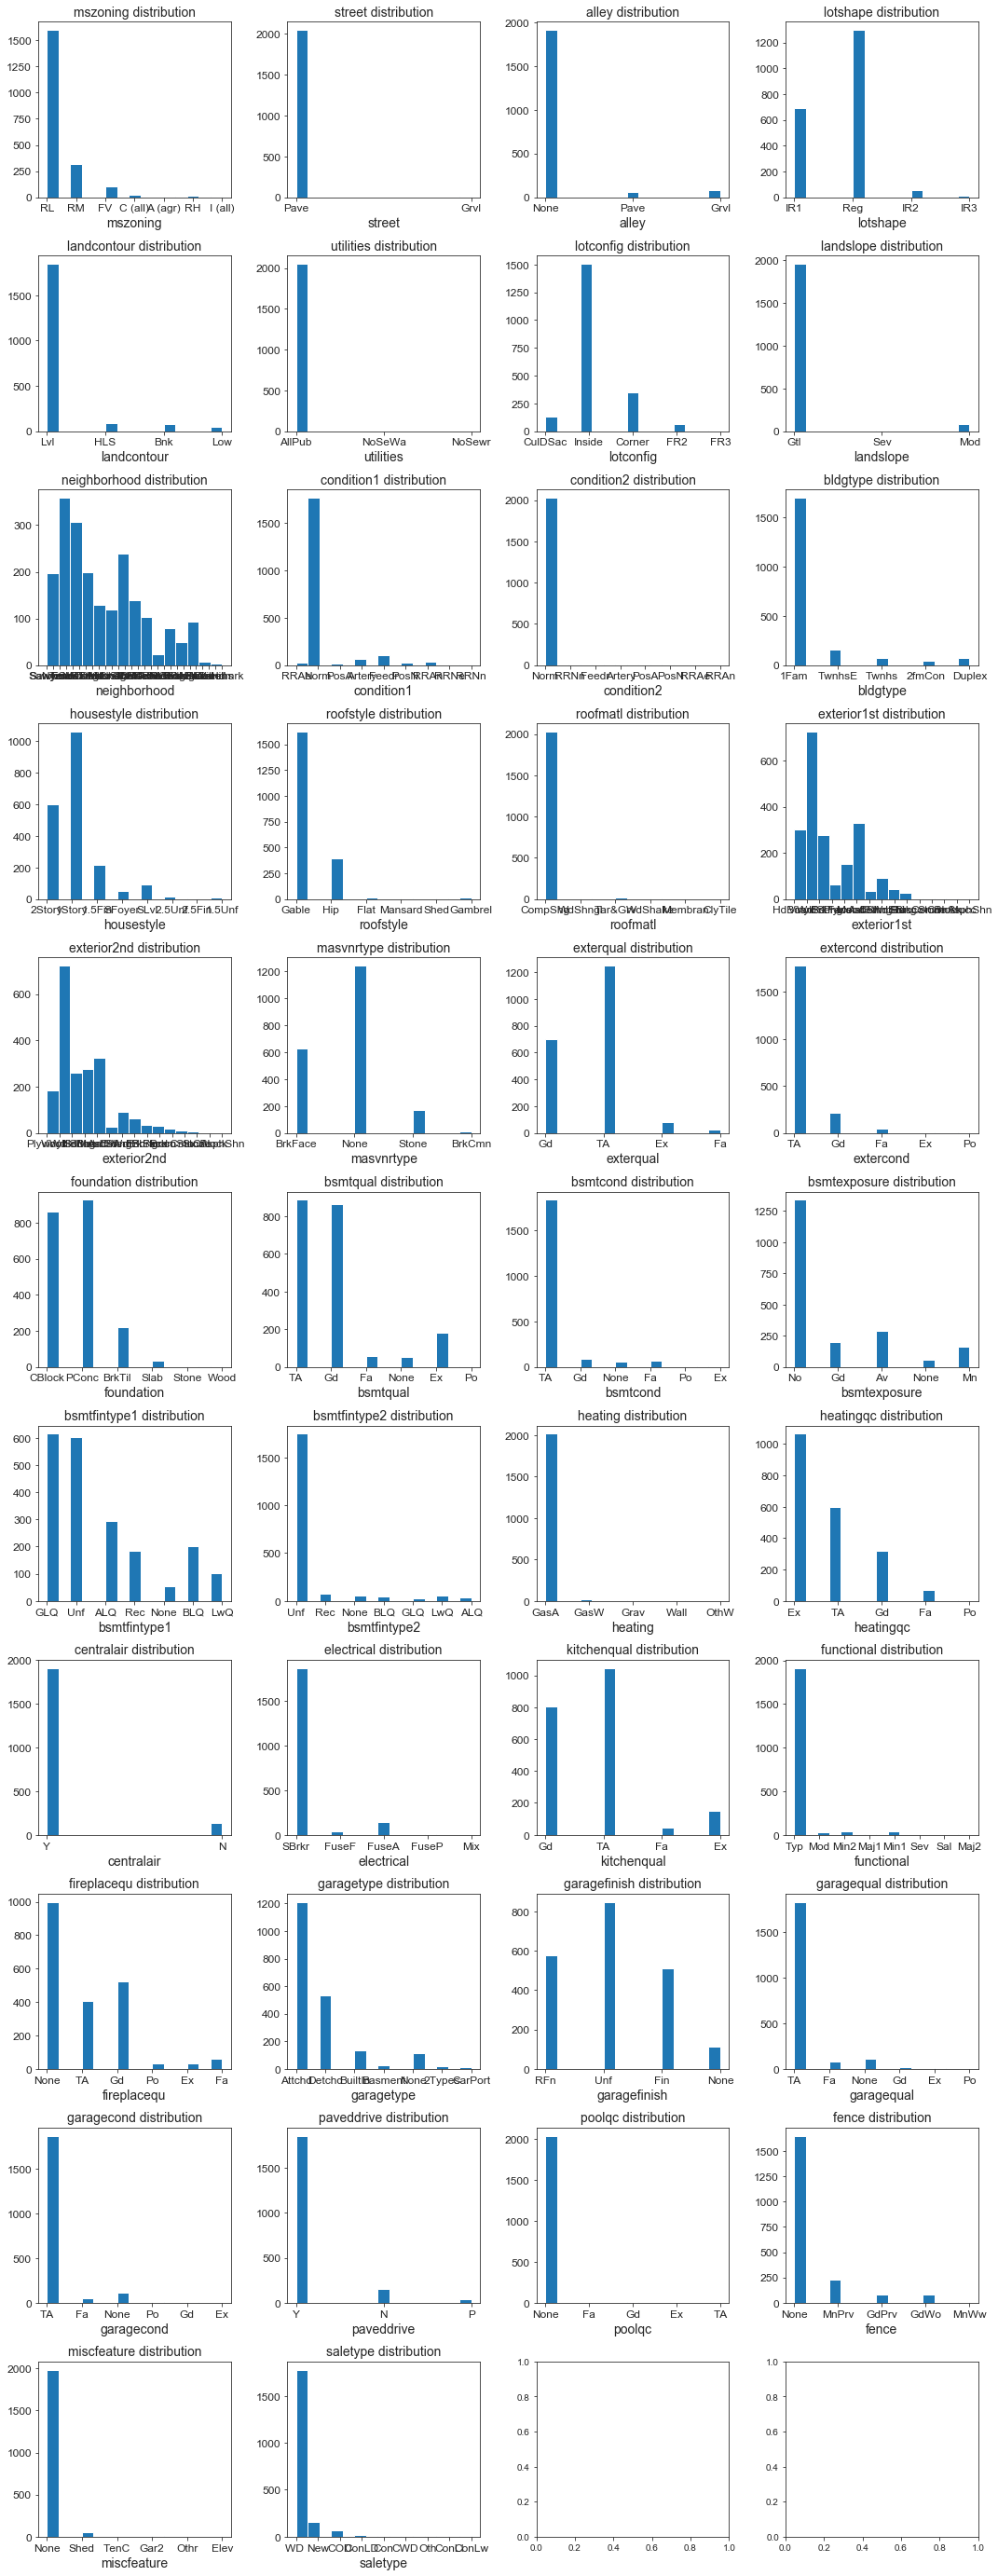

In [16]:
subplot_histograms(train_copy,col_categorical)

#### Boxplots (categorical variables)

Some categorical features look like they may affect saleprice, such as `neighborhood`, `condition1`, `condition2`, and `kitchenqual`.

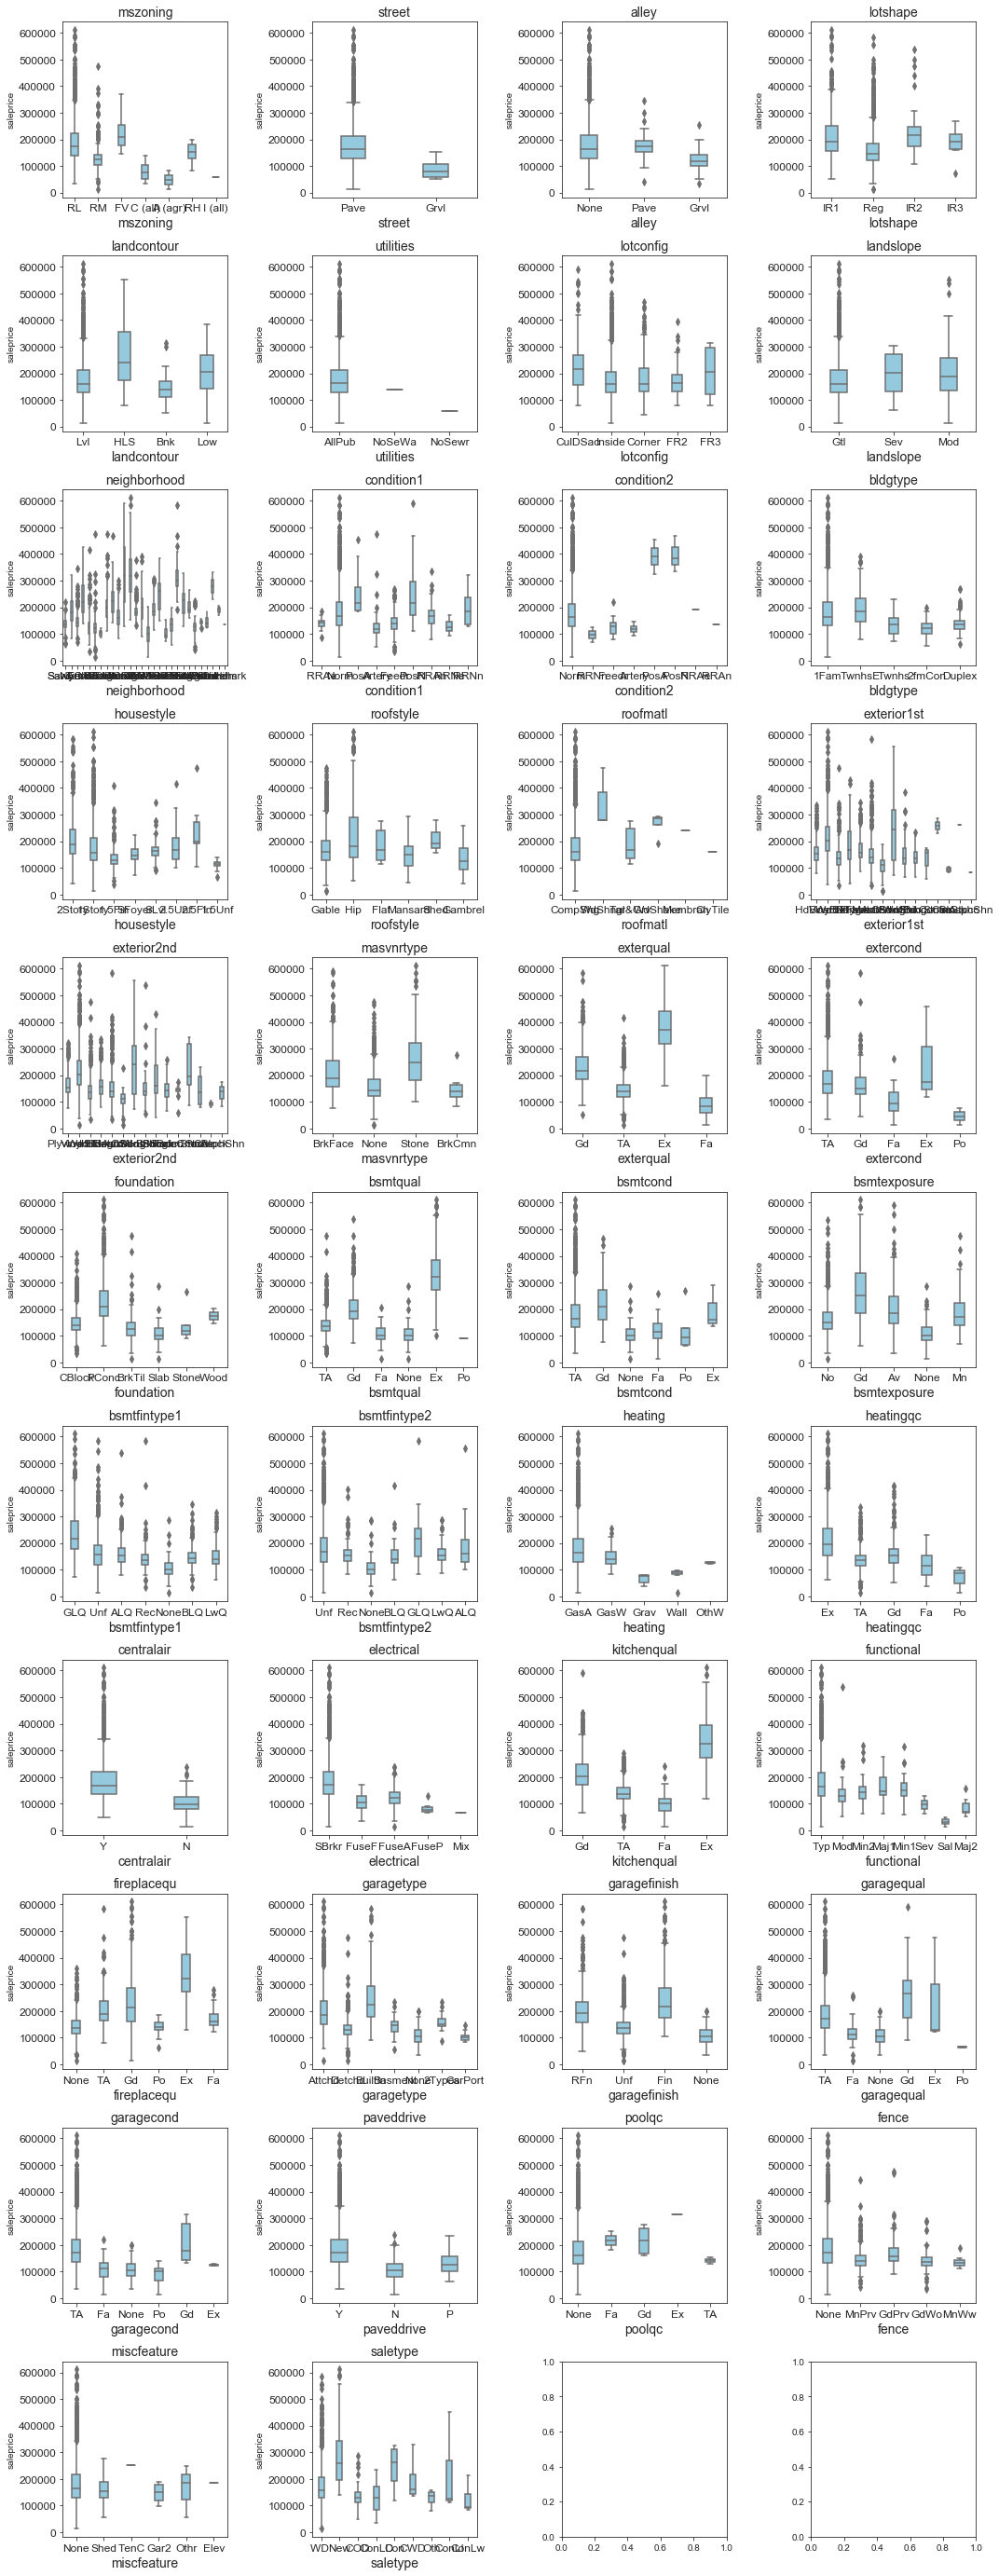

In [17]:
subplot_box(train_copy, col_categorical)

#### Relationship with saleprice, and outliers

From the scatterplots below, one can see a relatively linear relationship between `saleprice` and several of the features, for example, `overallqual`, `yearbuilt`, `totalbsmtsf`, `1stflrsf`, `grlivarea`, `totrmsabvgrd`, `fireplaces`, `garagecars`, and `garagearea`. Many of these represent areas, therefore area is likely to be an important predictor of `saleprice`.

There are also a few obvious outliers, in 
- `lotarea`
- `lotfrontage`
- `1stflrsf`
- `bsmtfinsf1`
- `grlivarea`

These are houses with very large areas/very long lot frontage but very low prices. These are likely the same 2 points and will be removed during feature engineering.

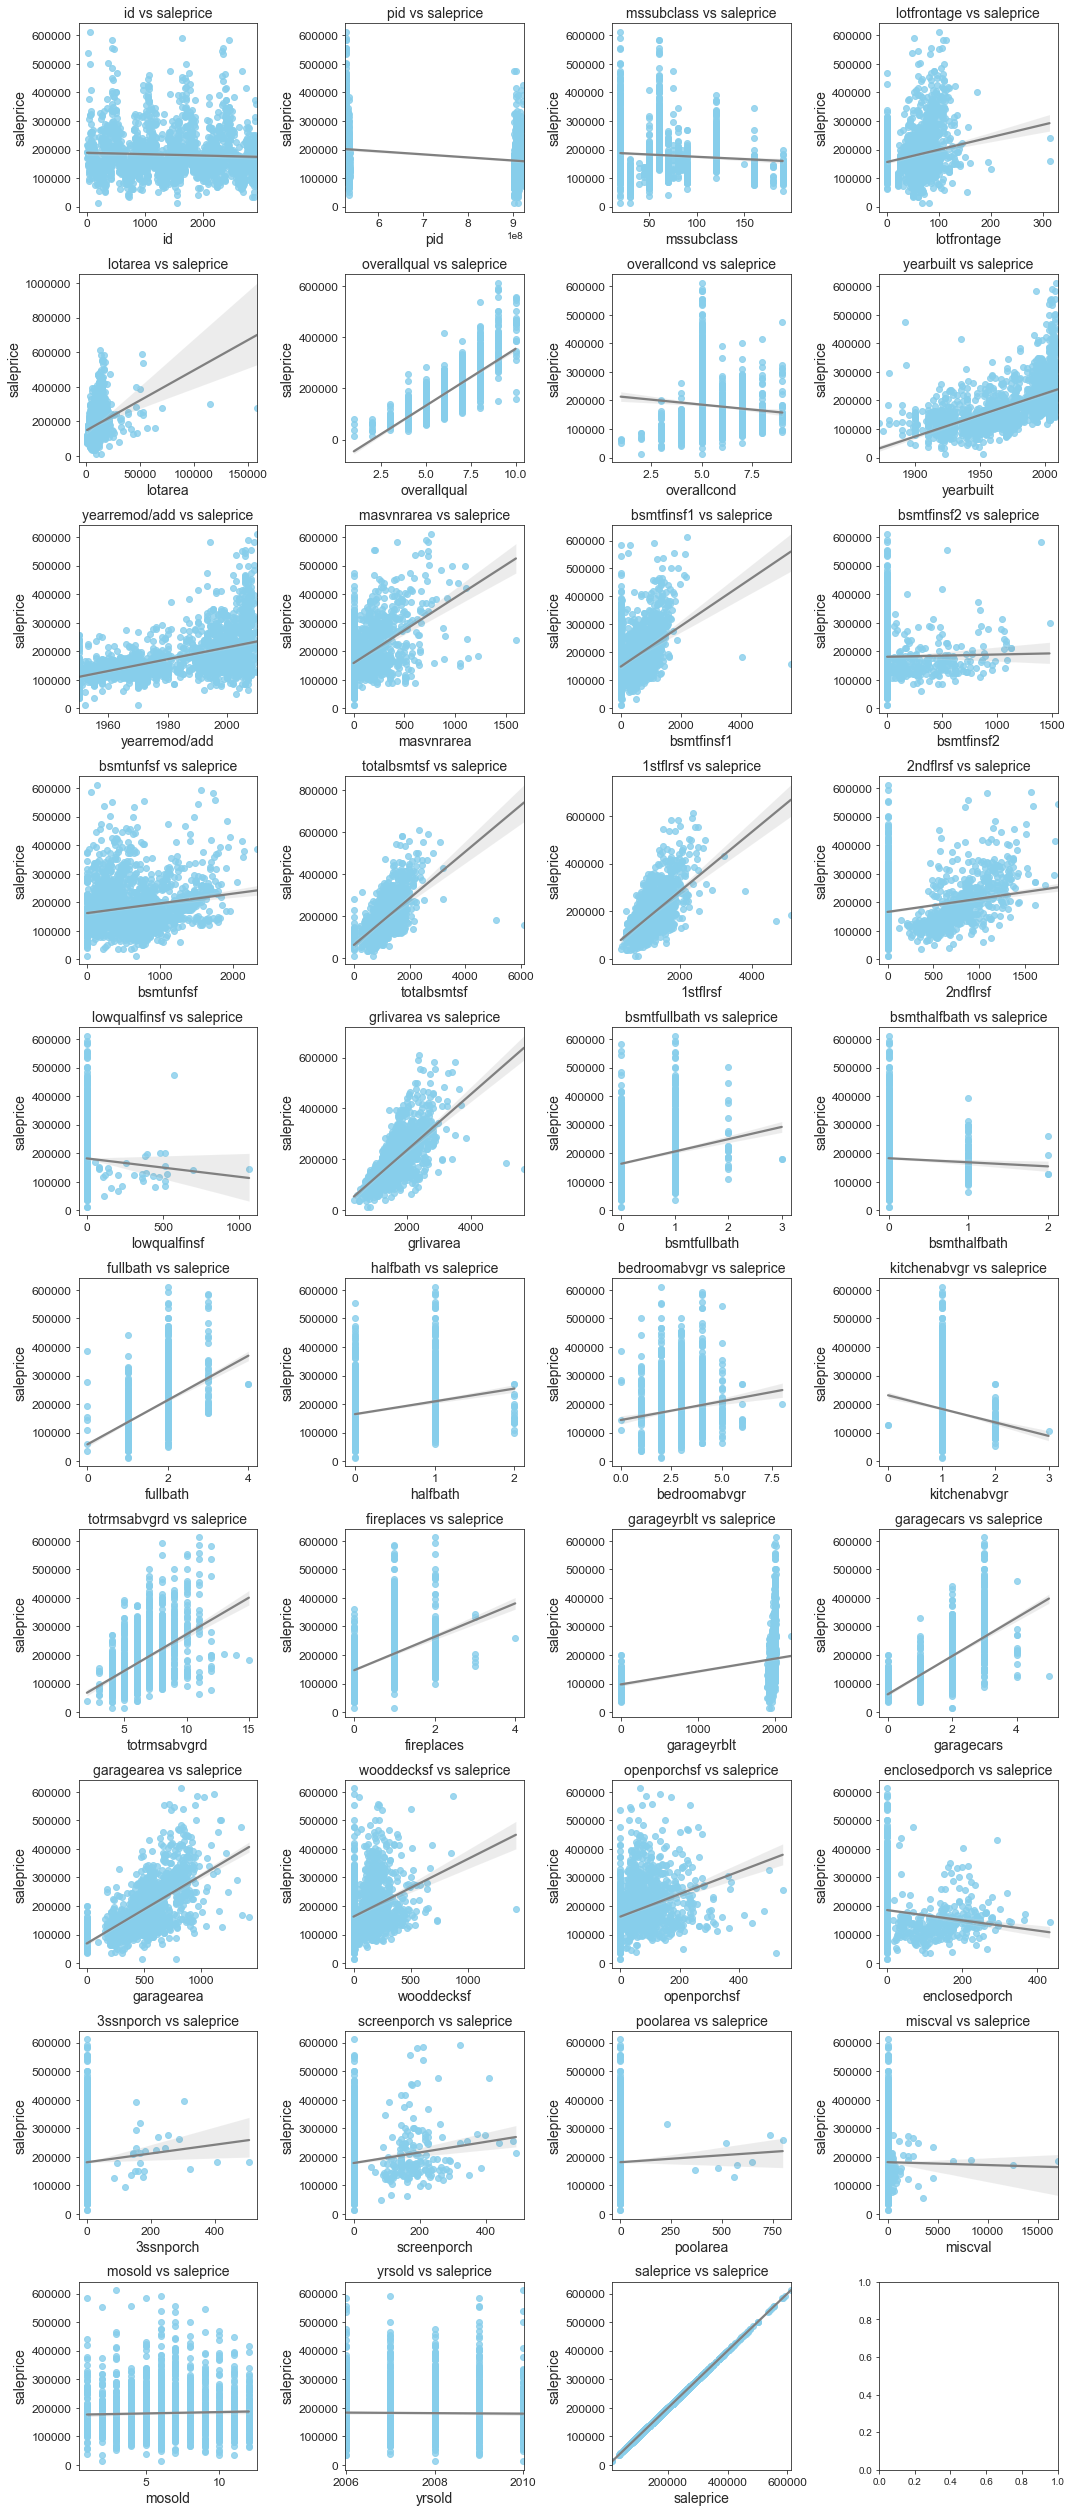

In [18]:
subplot_scatter(train_copy,col_numerical)

#### Skewed features

The table below shows the top 10 most skewed features and their Fisher-Pearson coefficient of skewness.

In [19]:
from scipy.stats import skew

skewed = train_copy[col_numerical].apply(lambda x: skew(x.astype(float)))
skewed = skewed[skewed > 0.3]
skewed_df = pd.DataFrame({'skewed':skewed})
skewed_df.skewed.sort_values(ascending=False).head(10)

miscval          20.642287
poolarea         16.688012
3ssnporch        11.818550
lowqualfinsf     11.492876
lotarea           9.198217
kitchenabvgr      4.345094
bsmtfinsf2        4.238037
bsmthalfbath      3.946384
screenporch       3.856287
enclosedporch     2.862817
Name: skewed, dtype: float64

## Closer examinations

Based on the distribution graphs above, several of the features needed a closer look in order to determine the appropriate feature engineering procedure.

### Exterior materials

Seems like most of the houses have a single exterior material, and for the few with two materials, the materials are mostly of similar type (e.g. wood single and wood siding), or misspelt (e.g. cemntbd and cment bd). Therefore `exterior2nd` will be dropped during feature engineering, and `exterior1st` will be grouped into a few more general categories, e.g. stone, cemend, wood, metal, etc.

In [20]:
# combining exterior1st and exterior 2nd if their materials are different
for index, val in enumerate(train_copy.exterior1st):
    if val != train_copy.loc[index, 'exterior2nd']:
        train_copy.loc[index, 'exterior'] = val + " / " + train_copy.loc[index, 'exterior2nd']
    else:
        train_copy.loc[index, 'exterior'] = val

In [21]:
pd.DataFrame(train_copy.exterior.value_counts()).head(40)

,exterior
VinylSd,712
MetalSd,321
HdBoard,259
Wd Sdng,236
Plywood,124
CemntBd / CmentBd,89
WdShing / Wd Shng,34
BrkFace,32
HdBoard / Plywood,27
AsbShng,25


### `landslope`

As there are relatively few houses with 'severe' slopes, this category will be grouped with 'moderate'.

In [22]:
train_copy.landslope.value_counts()

Gtl    1953
Mod      88
Sev      10
Name: landslope, dtype: int64

### Porches

Most houses have 0sf of porch. Therefore houses with areas >0 for any porch will be combined into a single column indicating the presence of a porch.

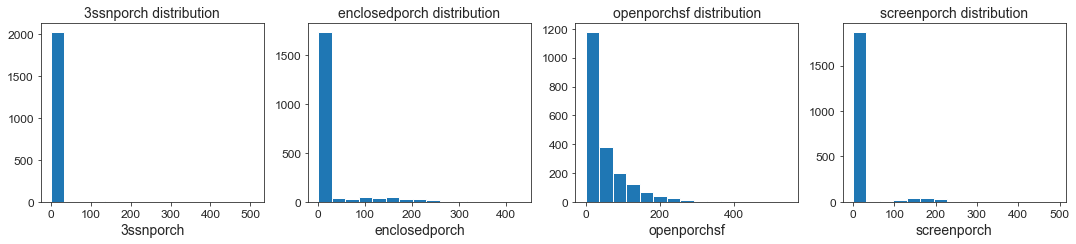

In [23]:
# check distribution of porch columns
col_porch = ['3ssnporch','enclosedporch','openporchsf','screenporch']
subplot_histograms(train_copy, col_porch)

### `miscfeature`

The only category in this column with a likely-signficant sample size is shed. It will therefore be converted into a shed-presence column.

In [24]:
train_copy.miscfeature.value_counts()

None    1986
Shed      56
Gar2       4
Othr       3
Elev       1
TenC       1
Name: miscfeature, dtype: int64

### `yrbuilt` and `yrsold`

A new column will be added indicating the age of the house when sold. Most houses are quite new when sold. There is one house with -1 age, and will be removed.

,age_sold
-1.0,1
0.0,80
1.0,154
2.0,62
3.0,44
...,...
127.0,1
128.0,2
129.0,1
135.0,1


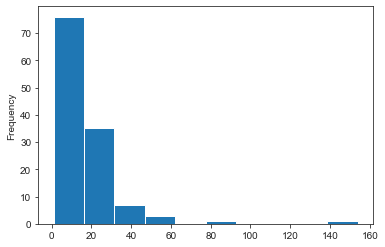

In [25]:
# get the difference between year built and year sold
for index, val in enumerate(train_copy.yearbuilt):
    if val == train_copy.loc[index, 'yrsold']:
        train_copy.loc[index, 'age_sold'] = 0
    else:
        train_copy.loc[index, 'age_sold'] = train_copy.loc[index,'yrsold'] - val

# check distribution of age sold
train_copy.age_sold.value_counts().plot(kind = 'hist')
pd.DataFrame(train_copy.age_sold.value_counts()).sort_index()

### Whether remodelling was done

A column will be added for whether or not remodelling had been done on the house. 1101 houses had no remodelling done - i.e. the year the house was built was the same as the year the house was remodelled. About half of the houses had been remodelled.

In [26]:
# since yearremod/add is the same as yearbuilt if there's no remodel - 
# check how many of them are the same (i.e. no remodeling had been done)
print(len(train_copy[train_copy['yearremod/add']==train_copy['yearbuilt']]\
                                                  [['yearremod/add','yearbuilt']]))

1101


### `salesprice` vs `mosold`

The data available seems to be limited to 5 months on even years and 4 months on odd years (i.e. Jan, Mar, May, Jul, Sep in 2006 and Feb, Apr, Jun, Aug in 2007). Looking at the graph of saleprice as a function of time, there does not seem to be any obvious trend at first glance.

In [27]:
# create combined col for year sold and month sold
for n in range(len(train['yrsold'])):
    train.loc[n,'yrmosold'] = str(train.loc[n,'yrsold'])[:4] + "-" + str(train.loc[n,'mosold'])[:1]

train['yrmosold'] = pd.to_datetime(train['yrmosold'],format = '%Y/%m')

In [28]:
train['yrmosold'].astype(str).unique()

array(['2010-03-01', '2009-04-01', '2010-01-01', '2010-04-01',
       '2010-06-01', '2006-06-01', '2010-05-01', '2007-06-01',
       '2007-09-01', '2008-07-01', '2006-02-01', '2009-06-01',
       '2008-01-01', '2008-06-01', '2008-05-01', '2007-04-01',
       '2007-05-01', '2009-01-01', '2006-07-01', '2006-01-01',
       '2007-07-01', '2009-07-01', '2006-04-01', '2009-09-01',
       '2006-09-01', '2008-02-01', '2010-02-01', '2006-03-01',
       '2007-08-01', '2007-01-01', '2008-09-01', '2008-04-01',
       '2009-08-01', '2007-02-01', '2009-03-01', '2009-05-01',
       '2006-05-01', '2006-08-01', '2008-08-01', '2010-07-01',
       '2008-03-01', '2009-02-01', '2007-03-01'], dtype=object)

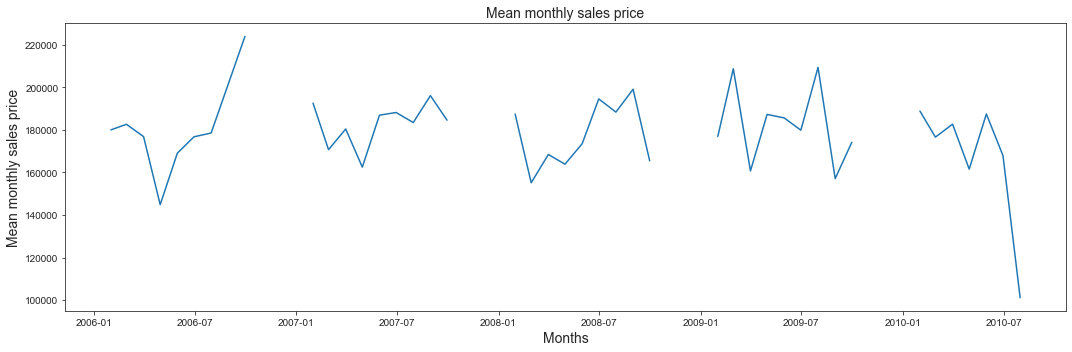

In [29]:
monthlyprice = train.set_index('yrmosold')

# resampling df to get monthly means
monthlyprice = monthlyprice.resample('M').mean()

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(monthlyprice.index,monthlyprice['saleprice'])
ax.set_xlabel("Months", fontsize=14)
ax.set_ylabel("Mean monthly sales price",fontsize=14)
ax.set_title("Mean monthly sales price", fontsize=14)

plt.tight_layout()

### `garageyrblt` and `yearbuilt`

Most of the garages were built the same year as the house, so the `garageyrblt` column will be dropped.

In [30]:
train_copy.garageyrblt

len(train_copy[train_copy['garageyrblt']==train_copy['yearbuilt']])

1564

### `1stflrsf` and `grlivarea`

A lot of these values look like the same - they probably have the same value if the house only has 1 floor. Digging deeper, it seems like grlivarea is a sum of living areas on the first floor, second floor, and any above, and for most (2018) of the houses, grlivarea is the same as the 1st floor area plus the 2nd floor area. Therefore, the following will be done:
- `1stflrsf` will be deleted
- `2ndflrsf` will be converted to a second floor presence column
- houses with `grlivarea` bigger than the sum of 1st and 2nd floors will be placed into a new `bighouses` column

In [31]:
# check how many of 1stflrsf and grlivarea are the same
print(len(train_copy[train_copy['1stflrsf']==train_copy['grlivarea']]\
                                                  [['1stflrsf','grlivarea']]))

1176


In [32]:
# check those that are different
train_copy[train_copy['1stflrsf']!=train_copy['grlivarea']]\
                                                  [['1stflrsf','grlivarea']]

,1stflrsf,grlivarea
0,725,1479
1,913,2122
3,744,1444
4,831,1445
9,1040,2080
...,...,...
2042,964,1414
2043,608,1232
2044,754,1609
2048,1172,1913


In [33]:
# get sum of 1stflr and 2ndflr area
train_copy['flrsf'] = train_copy['1stflrsf']+train_copy['2ndflrsf']

# check how many of these and grlivarea are the same
print(len(train_copy[train_copy['flrsf']==train_copy['grlivarea']]\
                                                  [['flrsf','grlivarea']]))

2018


In [34]:
for index, val in enumerate(train_copy['flrsf']):
    if val == train_copy.loc[index, 'grlivarea']:
        train_copy.loc[index, 'bighouse'] = 0
    else:
        train_copy.loc[index, 'bighouse'] = 1

In [35]:
train_copy['bighouse'].value_counts()

0.0    2018
1.0      33
Name: bighouse, dtype: int64

## Collinear features
---

### Correlation heatmap (of numerical columns)

From the heatmap it looks like some of the variables are highly correlated with each other. 
- `garagecars` and `garagearea` (_garage area increases with increasing number of cars that can fit in it_)
- `gotalrmsabvgrd` and `grlivarea` (_area increases with increasing number of rooms_)
- `1stflrsf` and `totalbsmtsf` (_the first floor is on top of the basement, so they likely have similar size_).

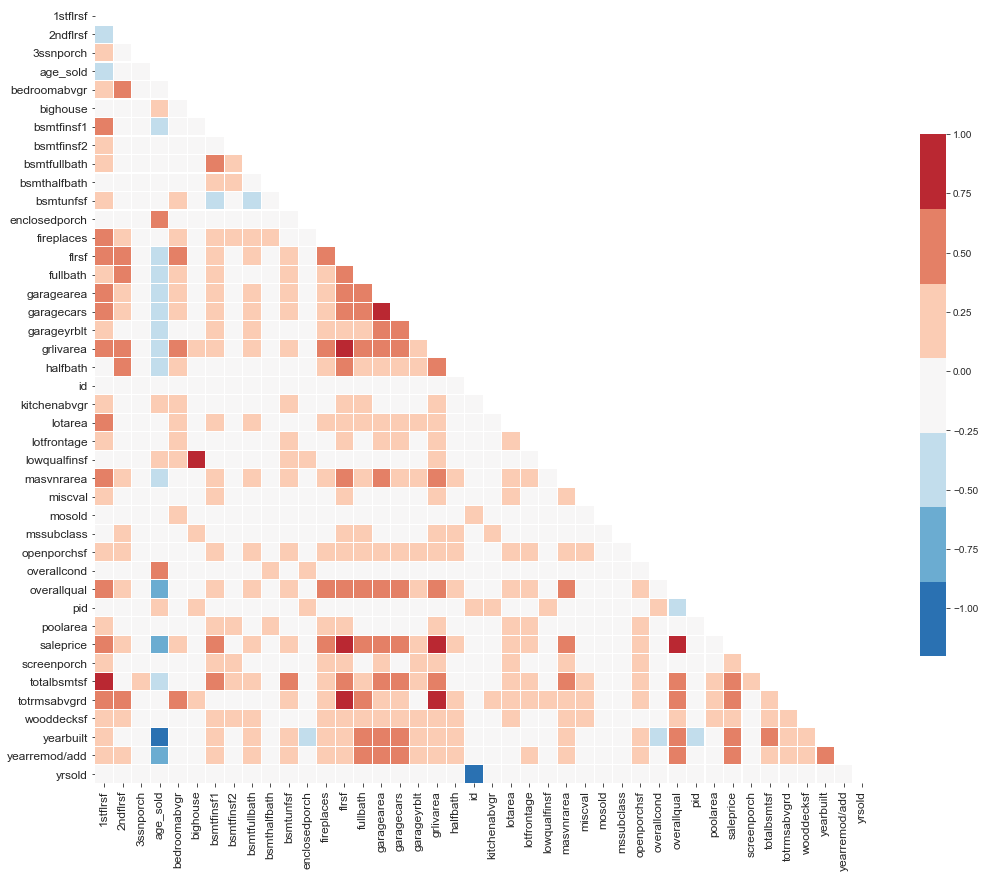

In [36]:
# order columns
train_copy = train_copy[train_copy.columns.sort_values()]

# plot heatmap
mask = np.zeros_like(train_copy.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(train_copy.corr(),
            mask = mask,
            square=True,
            vmin = -1.2,
            vmax = 1,
            linewidth=0.1,
            cbar_kws = {'shrink':0.5},
            cmap=sns.color_palette("RdBu_r", 7))
ax.tick_params(labelsize=12)
plt.tight_layout()

## Possible explanatory variables

The correlation heatmap below shows the ten features that have the highest correlation coefficient with saleprice. These include categorical features as well as the features were first dummy-encoded. There are no negative correlation coefficients among these, meaning everything is positively correlated with saleprice. **`overallqual`** has the highest correlation with `saleprice`. 

There are also some collinear features. 

The pairplots of these 10 features further show their relationship with saleprice, as well as the presence of collinearity (e.g. between `1stflrsf` and `grlivarea`).

In [37]:
# one-hot encode categorical columns
train_dummies = pd.get_dummies(train_copy)
# drop_first = True

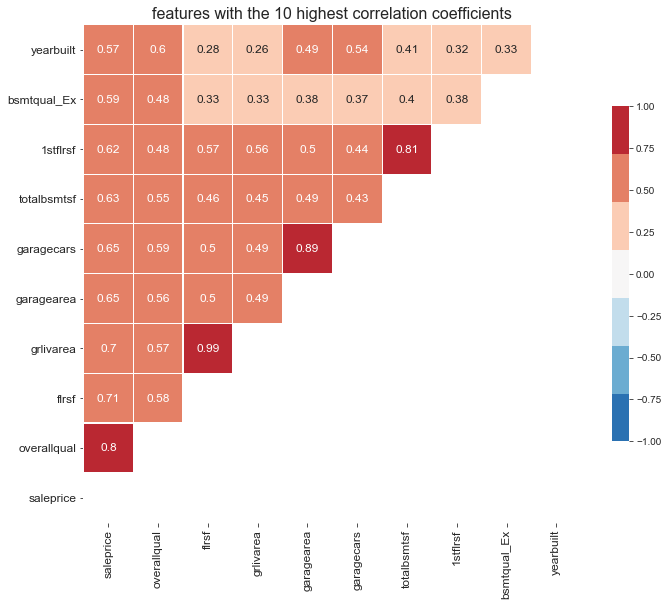

In [38]:
# get index of columns with 10 highest corrcoef wrt saleprice
corr_cols = train_dummies.corr().nlargest(10, 'saleprice').index

# create heatmap
mask = np.zeros_like(train_dummies[corr_cols].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(train_dummies[corr_cols].corr(), 
            annot=True, 
            square= True, 
            mask = mask,
            cmap=sns.color_palette("RdBu_r", 7),
            annot_kws={'size': 12},
            cbar_kws={"shrink": 0.5},
            linewidth = 0.1,
            yticklabels=corr_cols.values, 
            xticklabels=corr_cols.values,
            vmin = -1)
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.tick_params(labelsize=12)
plt.title('features with the 10 highest correlation coefficients', fontsize=16)
plt.tight_layout()

RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density.

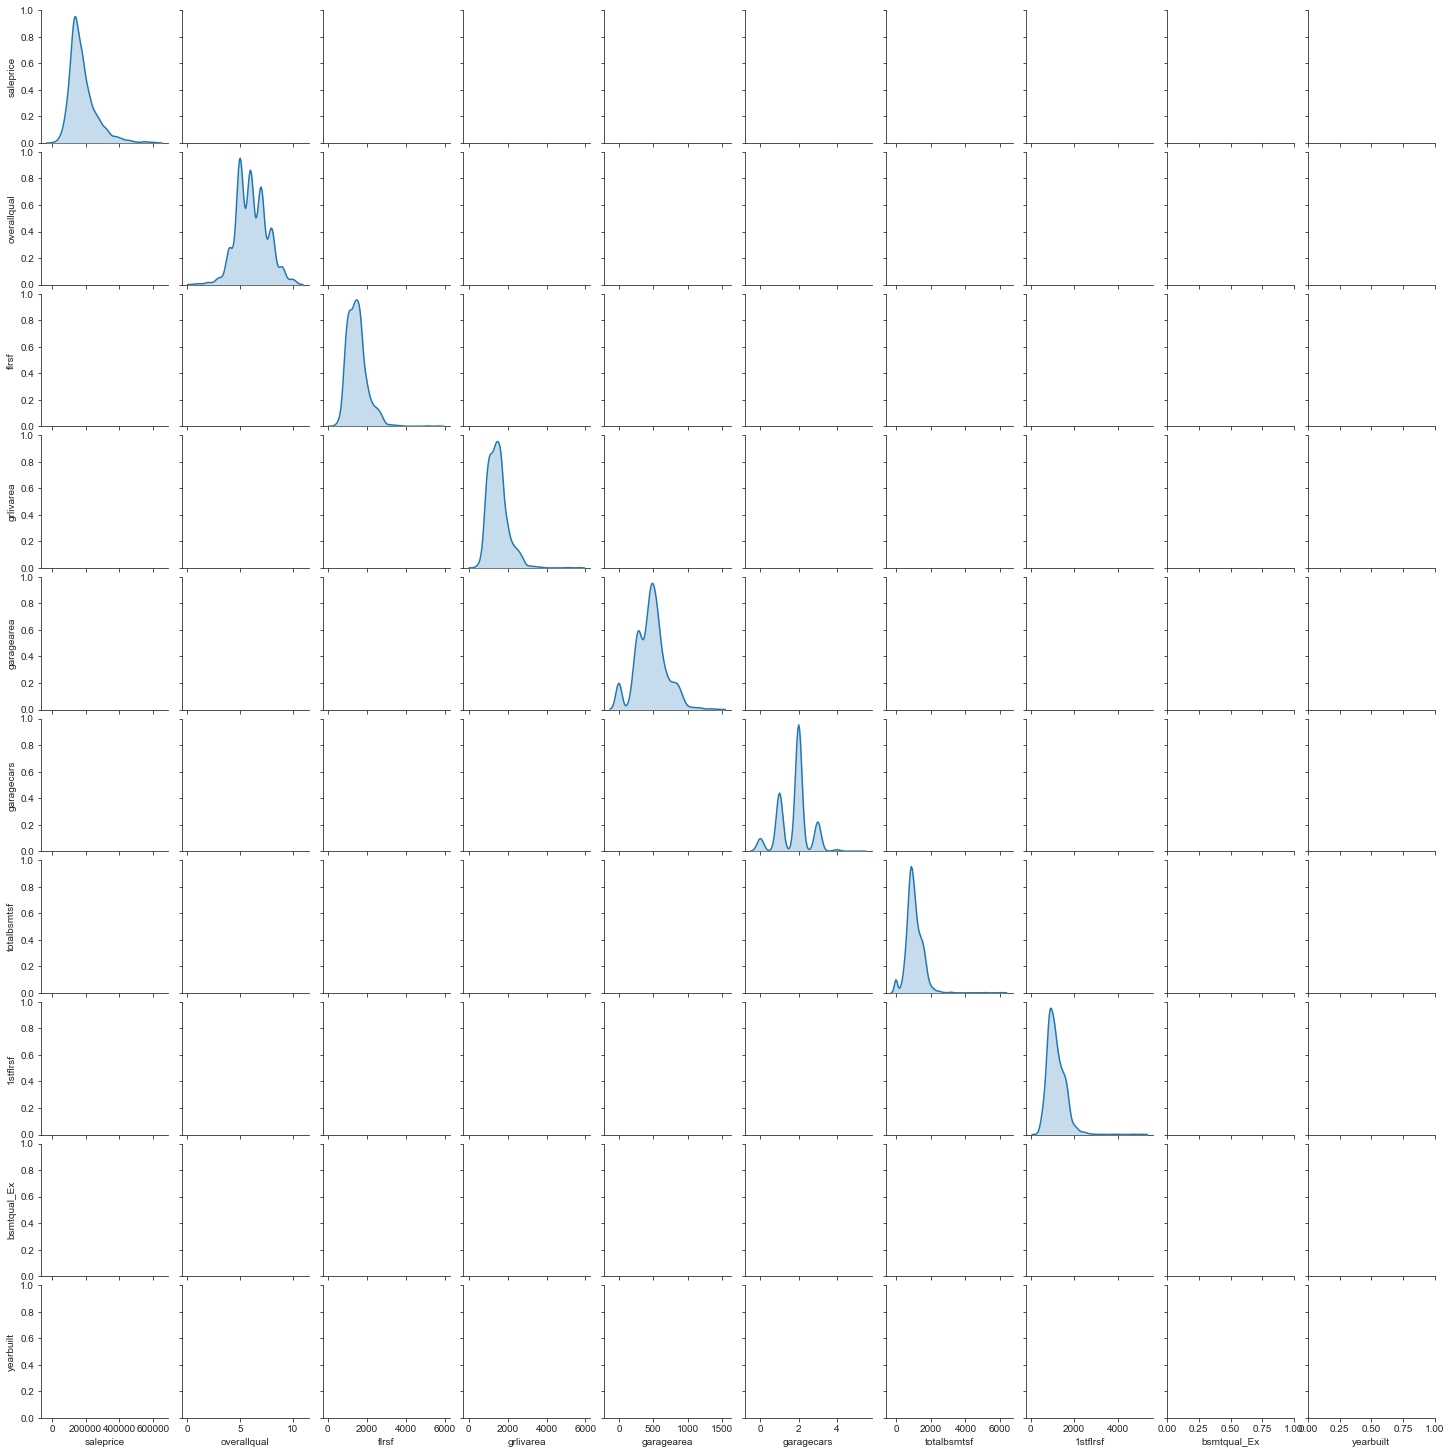

In [39]:
sns.pairplot(train_dummies[corr_cols],size = 2 ,kind ='scatter',diag_kind='kde')
plt.tight_layout()

## Conclusion
___

The above EDA revealed several issues with the data, such as the presence of null values and columns with skewed distributions. These features will be cleaned and preprocessed in the next notebook in this project, [2 - Preprocessing and Feature Engineering](./2_preprocessing_and_feature_engineering.ipynb).

From the EDA, one can already get a basic idea of the features that could most affect house price, based on the relationship with saleprice revealed in [scatterplots](#Relationship-with-saleprice-and-outliers) and the [correlation heatmap](#Possible-explanatory-variables). Area (e.g. (`grlivearea`, `garagearea`, `totalbsmtsf`) is likely to be one of the most important factor affecting house price. The age of the house (`yearbuilt`) is also likely to be important. However, as categorical variables (such as `neighborhood`) were unable to be shown in these graphs, whether or not they would affect `saleprice` would only be revealed in the [model-building notebook](./3_model_tuning_and_insights.ipynb). 